ML Course, Bogotá, Colombia  (&copy; Josh Bloom; June 2019)

In [1]:
%run ../talktools.py

# Learning on Sequences

Time series data (e.g., from sensors) and text are classic examples of sequential data types. 

We saw in the first lecture how to featurize time series and natural language. We saved the features from our TF-IDF work on the dual newsgroup classification challenge. Let's reload that now and learn a model.

In [2]:
import numpy as np
data = np.load("../1_ComputationalAndInferentialThinking/tfidf.npz")
X = data["X"]
y = data["y"]

print(f"Baseline accuracy from random guessing: {y.sum()/len(y):0.3f}")

Baseline accuracy from random guessing: 0.500


In [3]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# 3 choices of mtry
parameters = {'n_estimators':[100],  'max_features':[5, 8,10,'auto'], 
                        'criterion': ['gini','entropy']}

rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                   n_jobs = -1, cv = 5,verbose=1)
rf_opt = rf_tune.fit(X, y)

print("Best zero-one score: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best zero-one score: 0.8609941027801179

Optimal Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.1s finished


As noted in that first lecture, TF-IDF tends to remove the context that words appear in sentences and with respect to each other.  BoW and TF-IDF features also tend to be sparse making them more challenging, in general, to learn on. One way to make text feature dense (instead of sparse) is using **hashing**.

> In machine learning, feature hashing, also known as the hashing trick...is a fast and space-efficient way of vectorizing features, i.e. turning arbitrary features into indices in a vector or matrix. It works by applying a hash function to the features and using their hash values as indices directly, rather than looking the indices up in an associative array. -- Wikipedia

See also https://arxiv.org/abs/1805.08539

In [4]:
strings = ["Colombia", "Bogotá", "Python", "Python ", "python"]

table_hash_size = 10
# ↑ Changing the number is a trade-off between how small I want my feature
# set and how many conflicts I can tolerate or want.

hash_table = np.zeros(shape=(table_hash_size,))

for s in strings:
    print(f"hash of {s} = {hash(s)}...modulo {table_hash_size} = {hash(s) % table_hash_size}")
    hash_table[hash(s) % table_hash_size] += 1
    
print(f"Feature hash: {hash_table}")

hash of Colombia = -375700258898031251...modulo 10 = 9
hash of Bogotá = -6239989452414784828...modulo 10 = 2
hash of Python = 7316945023390029172...modulo 10 = 2
hash of Python  = -1119563628606443890...modulo 10 = 0
hash of python = -8179798644239604634...modulo 10 = 6
Feature hash: [1. 0. 2. 0. 0. 0. 1. 0. 0. 1.]


### Notes:

When you hash strings even when they are close you get extremely different answers, that's desired. Example `Python` and  `python`.

In [5]:
from sklearn.datasets import fetch_20newsgroups
news_train = fetch_20newsgroups(subset='train', categories=['sci.space','rec.autos'], data_home='datatmp/')

> This class turns sequences of symbolic feature names (strings) into `scipy.sparse matrices`, using a hash function to compute the matrix column corresponding to a name. The hash function employed is the signed 32-bit version of Murmurhash3.

In [6]:
from sklearn.feature_extraction import FeatureHasher
import re

def tokens(doc):
    """Extract tokens from doc.

    This uses a simple regex to break strings into tokens. .
    """
    return (tok.lower() for tok in re.findall(r"\w+", doc))


h = FeatureHasher(n_features=10, input_type='string')
f = h.transform([tokens(x) for x in news_train.data])
f.toarray()

array([[ 6.,  2.,  0., ...,  0.,  8., -6.],
       [ 6., 13.,  3., ..., -4.,  3., -2.],
       [ 6., -1.,  5., ..., -1., -9.,  3.],
       ...,
       [ 4., -2.,  6., ..., -2.,  0., -2.],
       [ 0., -2.,  3., ..., -2.,  2., -4.],
       [ 3.,  1.,  0., ..., -6., -3.,  2.]])

In [7]:
f.shape  # 1187 documents, 10 features

(1187, 10)

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50)
clf.fit(f, news_train.target)

# make predictions for testing set
pred_rf = clf.predict(f) 
print(pred_rf)
print(news_train.target)

[1 0 0 ... 1 0 0]
[1 0 0 ... 1 0 0]


In [9]:
# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(news_train.target, pred_rf) # zero-one loss
rf_01_score = metrics.accuracy_score(news_train.target, pred_rf) # zero-one score
rf_confmat = metrics.confusion_matrix(news_train.target, pred_rf) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
print(rf_confmat)

Zero-One Loss: 0.0
Zero-One Score: 1.0
Confusion Matrix:
[i, j] is the # of objects truly in group i but predicted to be in group j
[[594   0]
 [  0 593]]


### Notes:

In the first case we got a perfect match/prediction, which is scary, what was done wrong is that we didnt really hold out anything as test data, so we are fitting over the complete data set.

This is a very nice way of taking what could be a large dimensional feature space and making it more compact. We still are interesting in understand how we might use the context surrounding words to get a more nuianced and predictive **embedding**.

> Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model). -- https://www.tensorflow.org/tutorials/representation/word2vec

<img src="https://cdn-images-1.medium.com/max/1600/1*Yb-ex-FKu3YBv46XMG2xcA@2x.png">

Learning this model will try to make words that are similar have a similar output (embedding) vector.


> Word2vec, introduced in Distributed Representations of Words and Phrases and their Compositionality (Mikolov et al., NIPS 2013), has attracted a lot of attention in recent years due to its efficiency to produce relevant word embeddings (i.e. vector representations of words). Word2vec is a shallow neural network trained on a large text corpus. The meaning of a word is learned from its surrounding words in the sentences and encoded in a vector of real values.  -- https://www.kernix.com/blog/similarity-measure-of-textual-documents_p12

`spacy` has pretrained models that turn tokens into vectors, trained off of a large corpus from the internet.

In [10]:
# optional: this will take awhile the first time -- it's 0.83 GB in size!
# !python -m spacy download en_core_web_lg

In [11]:
import en_core_web_lg
nlp = en_core_web_lg.load()

ModuleNotFoundError: No module named 'en_core_web_lg'

In [ ]:
token = nlp(u'dog')

In [ ]:
token.vector.shape

Because we have a 300-length vector, we can ask what the angle is between vectors (cosine similarity):

In [ ]:
tokens = nlp(u'dog cat banana')

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

In [ ]:
king = nlp(u'king')
queen = nlp(u'queen')
man = nlp(u'man')
woman = nlp(u'woman')

from scipy import spatial
spatial.distance.cosine(king.vector - man.vector + woman.vector, queen.vector)

<img src="http://jalammar.github.io/images/word2vec/queen-woman-girl-embeddings.png">

<img src="http://jalammar.github.io/images/word2vec/king-analogy-viz.png">

In [ ]:
target = nlp("Ponies are beautiful animals.")
 
doc1 = nlp("Horses are amazing.")
doc2 = nlp("Dogs are barking animals.")
doc3 = nlp("Pirarucu, fish from the Amazon, taste great.")
 
print(target.similarity(doc1))  # 0.908860751681014
print(target.similarity(doc2))  # 0.8266815698382363
print(target.similarity(doc3))  # 0.6792794979241238

Talk on word2vec https://www.slideshare.net/ChristopherMoody3/word2vec-lda-and-introducing-a-new-hybrid-algorithm-lda2vec-57135994


https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb

Doc2vec on newsgroups: https://github.com/skillachie/nlpArea51/tree/master/doc2vec

## Timeseries 

We can think of understanding timeseries data in the context of convolutions.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

629


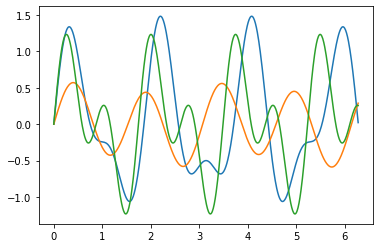

In [13]:
# here's a way to generate some 1D sources with some structure
# set by just a few parameters
def gen_timeseries(ts, period, harmonic_phase_amplitudes):
    timeseries = np.zeros(ts.shape)
    for i, (amp, phase) in enumerate(harmonic_phase_amplitudes):
        timeseries += amp*np.sin(  ((i+1)*period + phase)*ts)
    return timeseries

ts = np.arange(0, 2*np.pi, 0.01)
n_ts = len(ts)

plt.plot(ts, gen_timeseries(ts, 3, [(1.0, 0.5), (0.5, 0.5)]))
plt.plot(ts, gen_timeseries(ts, 2, [(0.1, 0), (0.5, 0.1)]))
plt.plot(ts, gen_timeseries(ts, 3.5, [(0.7, 0.1), (0.7, 0.2)]))
print(n_ts)

In [14]:
from itertools import chain
## make some training data
rnd = np.random.RandomState(seed=42)

n_training = 2000
n_testing = 500

P_training = rnd.rand(n_training)*9 + 1 # make periods from 1-10
ap = rnd.rand(n_training, 4)
ap[:, 1] *= 2*np.pi
ap[:, 3] *= 2*np.pi
spl = np.hsplit(ap, 2)
ampp = [[tuple(spl[0][i, :]), tuple(spl[1][i, :])] for i in range(n_training)]

X_train = []
y_train = []
for i in range(n_training):
    X_train.append(gen_timeseries(ts, P_training[i], ampp[i]))
    y_train.append([P_training[i]] + list(chain(*ampp[i])))

X_train = np.array(X_train)
y_train = np.array(y_train)

# Testing 

P_testing = rnd.rand(n_testing)*9 + 1 # make periods from 1-10
ap = rnd.rand(n_testing, 4)
ap[:, 1] *= 2*np.pi
ap[:, 3] *= 2*np.pi
spl = np.hsplit(ap, 2)
ampp = [[tuple(spl[0][i, :]), tuple(spl[1][i, :])] for i in range(n_testing)]

X_test = []
y_test = []
for i in range(n_testing):
    X_test.append(gen_timeseries(ts, P_testing[i], ampp[i]))
    y_test.append([P_testing[i]] + list(chain(*ampp[i])))

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
#y_train = np.expand_dims(y_train, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2000, 629, 1)
X_test shape: (500, 629, 1)
y_train shape: (2000, 5)
y_test shape: (500, 5)


/home/mefisto/anaconda3/envs/ml_course/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[9.55642876 0.27194973 4.77144    0.44973984 4.88021636]')

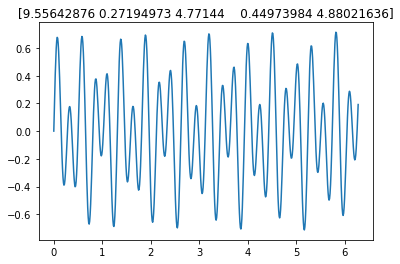

In [15]:
plt.plot(ts, X_train[1, :, 0])
plt.title(y_train[1])

One way to think about this challenge with time series classification is as a 1-D convolution.

In [16]:
from tensorflow.keras.models import Sequential  # linear stack of layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, AveragePooling1D


model = Sequential()
model.add(Convolution1D(filters=64, kernel_size=2, input_shape=(n_ts, 1), padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Convolution1D(filters=32, kernel_size=2, padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Convolution1D(filters=16, kernel_size=2, padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2))

model.add(Flatten())
model.add(Dropout(0.1)) # helps control overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_test.shape[1]))
model.add(Activation('linear'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 629, 64)           192       
_________________________________________________________________
activation (Activation)      (None, 629, 64)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 314, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 314, 32)           4128      
_________________________________________________________________
activation_1 (Activation)    (None, 314, 32)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 157, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 157, 16)           1

In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(), metrics=['mae', 'mse'])

In [19]:
model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)

Train on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 950us/sample - loss: 9.4233 - mae: 2.1067 - mse: 9.4233
Epoch 2/100
2000/2000 [==============================] - 1s 711us/sample - loss: 3.8709 - mae: 1.4634 - mse: 3.8709
Epoch 3/100
2000/2000 [==============================] - 1s 722us/sample - loss: 3.0762 - mae: 1.2471 - mse: 3.0762
Epoch 4/100
2000/2000 [==============================] - 1s 720us/sample - loss: 2.7111 - mae: 1.1744 - mse: 2.7111
Epoch 5/100
2000/2000 [==============================] - 1s 720us/sample - loss: 2.4815 - mae: 1.1322 - mse: 2.4815
Epoch 6/100
2000/2000 [==============================] - 1s 729us/sample - loss: 2.3138 - mae: 1.1008 - mse: 2.3138
Epoch 7/100
2000/2000 [==============================] - 1s 731us/sample - loss: 2.1475 - mae: 1.0669 - mse: 2.1475
Epoch 8/100
2000/2000 [==============================] - 2s 826us/sample - loss: 1.9715 - mae: 1.0277 - mse: 1.9715
Epoch 9/100
2000/2000 [===========================

2000/2000 [==============================] - 1s 717us/sample - loss: 1.0569 - mae: 0.6955 - mse: 1.0569
Epoch 71/100
2000/2000 [==============================] - 1s 703us/sample - loss: 1.0587 - mae: 0.6963 - mse: 1.0587
Epoch 72/100
2000/2000 [==============================] - 2s 781us/sample - loss: 1.0373 - mae: 0.6882 - mse: 1.0373
Epoch 73/100
2000/2000 [==============================] - 1s 744us/sample - loss: 1.0336 - mae: 0.6883 - mse: 1.0336
Epoch 74/100
2000/2000 [==============================] - 1s 716us/sample - loss: 1.0428 - mae: 0.6878 - mse: 1.0428
Epoch 75/100
2000/2000 [==============================] - 1s 723us/sample - loss: 1.0307 - mae: 0.6871 - mse: 1.0307
Epoch 76/100
2000/2000 [==============================] - 1s 732us/sample - loss: 1.0373 - mae: 0.6850 - mse: 1.0373
Epoch 77/100
2000/2000 [==============================] - 2s 873us/sample - loss: 1.0335 - mae: 0.6844 - mse: 1.0335
Epoch 78/100
2000/2000 [==============================] - 1s 735us/sample - l

In [20]:
pred = model.predict(X_test)

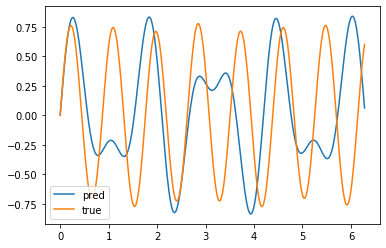

In [25]:
ind = 2
plt.plot(ts, gen_timeseries(ts, pred[ind][0],  [(pred[ind][1],pred[ind][2]), (pred[ind][3],pred[ind][4])]), label="pred")
plt.plot(ts, gen_timeseries(ts, y_test[ind][0],  [(y_test[0][1],y_test[0][2]), (y_test[0][3],y_test[0][4])]), label="true")
plt.legend()

Text(0, 0.5, 'Predicted period')

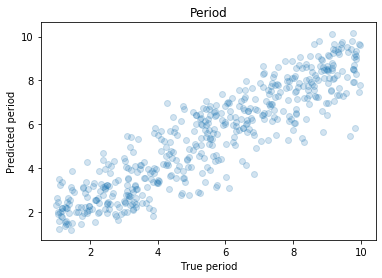

In [26]:
plt.scatter(P_testing, pred[:,0], alpha=0.2)
plt.title("Period")
plt.xlabel("True period")
plt.ylabel("Predicted period")

Text(0, 0.5, 'Predicted A')

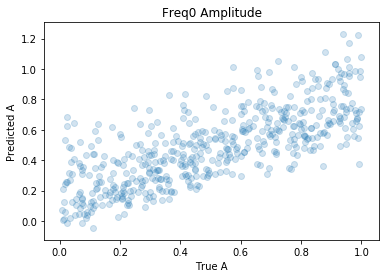

In [27]:
plt.scatter(y_test[:, 1], pred[:,1], alpha=0.2)
plt.title("Freq0 Amplitude")
plt.xlabel("True A")
plt.ylabel("Predicted A")

Text(0, 0.5, 'Predicted Phase')

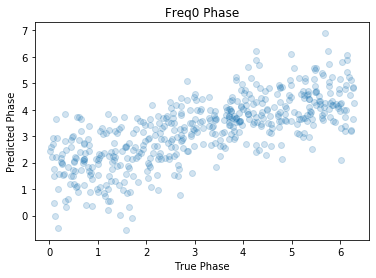

In [28]:
plt.scatter(y_test[:, 2], pred[:,2], alpha=0.2)
plt.title("Freq0 Phase")
plt.xlabel("True Phase")
plt.ylabel("Predicted Phase")

One of the difficulties with this is that convolutions don't easily contemplate the sequential nature of the data. We basically treated the first data point in the same way as the last data point. There are specific layers, called **recurrent neural networks** (RNNs), that handle the sequential nature of the input data (originally developed for language models). 

### Notes:

Conv nets don't really think or take into account **causality**, there are some nets that do take this into account. As follows:

<img src="https://mlalgorithm.files.wordpress.com/2016/08/rnn1.jpg">

### Notes:

* You do a recurrent neural net... this is a *many to one*, so every pass you get a number, because every neuron/node pass it to the next one and at the end all we get is a number in that layer.

A particular flavor of RNNs called LSTM (Long Short-Term Memory):

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png">

### Notes:

* The input goes 3 different directions and you also take the input of the previous observation, that is, the observation/prediction of the previous node/neuron in the same layer. 
* One of the main problems with RNNs is that they are extremely difficult to train... 
* They also tend to use a lot of RAM, so you need more memory in your device (CPU, GPU)... while they are also pretty slow, because they are sequential, or have some degree of it.

In [29]:
from tensorflow.keras.layers import LSTM, Dropout

> One difficulty when training LSTM with the full gradient is that the derivatives sometimes become excessively large, leading to numerical problems. To prevent this, [we] clipped the derivative of the loss with respect to the network inputs to the LSTM layers (before the sigmoid and tanh functions are applied) to lie within a predefined range. — Generating Sequences With Recurrent Neural Networks, 2013.

In [30]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(LSTM(128, input_shape=(n_ts, 1), activation='linear', 
                              return_sequences=True))
model.add(LSTM(128))
model.add(Dense(10, activation='relu'))
model.add(Dense(y_test.shape[1], activation="linear"))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 629, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
Total params: 199,489
Trainable params: 199,489
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(clipnorm=0.001, clipvalue=0.001), metrics=['mae', 'mse'])

In [33]:
model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1)

W0606 13:19:25.234355 140348228507456 deprecation.py:323] From /home/mefisto/anaconda3/envs/ml_course/lib/python3.6/site-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples
Epoch 1/2
2000/2000 [==============================] - 33s 17ms/sample - loss: nan - mae: nan - mse: nan
Epoch 2/2
2000/2000 [==============================] - 37s 18ms/sample - loss: nan - mae: nan - mse: nan


### Notes:

The previous example shows a persistence problem, that's why LSTMs kinda suck :)... you can fiddle with the parameters, for example clipping the gradient and such...

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg">
Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

RNN models are very fickle to train (exploding gradients, large amount of RAM, slow!). Temporal Convolutional Neutral nets are convnets that preserve causality. See https://github.com/philipperemy/keras-tcn

<img src="https://github.com/philipperemy/keras-tcn/raw/master/misc/Dilated_Conv.png">